In [1]:
%load_ext autoreload
%autoreload 2

# Introduction 

This notebook aims to do the following
1. Replicate (most) of the work done in the colab file
2. Integrate the blair model embedding as inputs
3. Use our input files (product and user) metadata instead of the hugging face ones 


# Imports

In [2]:
import os
import pandas as pd
import torch
import random
import numpy as np
import itertools

from datasets import load_dataset
from utils.setup_graph import make_mapping, create_nodes, train_test_validation_split
from utils.setup_embeddings import instantiate_users, custom_BLaIR_text_embedding_model
from utils.graph_model import BaseGNNRecommender, GNNRecommenderwithSkipConnections, GNNSAGERecommender, GNNSAGERecommenderwithSkipConnections
from utils.graph_helpers import train_model, plot_loss, plot_weights_heatmap_and_density, plot_activation_heatmap_and_density, plot_embedding_features, final_evaluation, make_hyperparameters_grid, grid_search_hyperparameters
from utils.recomendations import recommend_products, pretty_print_recomendations, paper_evaluation
from utils.test_metrics import calculate_ndcg_scores

# Load dataset

Original data as obtained from the colab notebook  
Additional data is obtained from the `All_Beauty_cleaned data` folder. 

In [3]:
reviews_dataset = load_dataset("McAuley-Lab/Amazon-Reviews-2023", "raw_review_All_Beauty", trust_remote_code=True)
product_dataset = load_dataset("McAuley-Lab/Amazon-Reviews-2023", "raw_meta_All_Beauty", split="full", trust_remote_code=True)

review_df = reviews_dataset['full'].to_pandas()
product_df = product_dataset.to_pandas()

In [4]:
agg_user_df = pd.read_csv("data/cleaned/user_metadata.csv")
new_product_df = pd.read_csv("data/cleaned/product_metadata.csv")

In [5]:
review_df.head()

,rating,title,text,images,asin,parent_asin,user_id,timestamp,helpful_vote,verified_purchase
0,5.0,Such a lovely scent but not overpowering.,This spray is really nice. It smells really go...,[],B00YQ6X8EO,B00YQ6X8EO,AGKHLEW2SOWHNMFQIJGBECAF7INQ,1588687728923,0,True
1,4.0,Works great but smells a little weird.,"This product does what I need it to do, I just...",[],B081TJ8YS3,B081TJ8YS3,AGKHLEW2SOWHNMFQIJGBECAF7INQ,1588615855070,1,True
2,5.0,Yes!,"Smells good, feels great!",[],B07PNNCSP9,B097R46CSY,AE74DYR3QUGVPZJ3P7RFWBGIX7XQ,1589665266052,2,True
3,1.0,Synthetic feeling,Felt synthetic,[],B09JS339BZ,B09JS339BZ,AFQLNQNQYFWQZPJQZS6V3NZU4QBQ,1643393630220,0,True
4,5.0,A+,Love it,[],B08BZ63GMJ,B08BZ63GMJ,AFQLNQNQYFWQZPJQZS6V3NZU4QBQ,1609322563534,0,True


In [6]:
product_df.sample(2)

,main_category,title,average_rating,rating_number,features,description,price,images,videos,store,categories,details,parent_asin,bought_together,subtitle,author
69809,All Beauty,Clinique 'Moisture Surge' Tinted Moisturizer S...,1.0,1,[],[],None,"{'hi_res': [None], 'large': ['https://m.media-...","{'title': [], 'url': [], 'user_id': []}",None,[],{},B01GJT78KK,None,None,None
50283,All Beauty,"Suitable for my blush, natural redness, contou...",4.0,84,[],[],None,{'hi_res': ['https://m.media-amazon.com/images...,"{'title': [], 'url': [], 'user_id': []}",SNOVO,[],"{""Item Form"": ""Powder"", ""Finish Type"": ""Matte""...",B08F31RLLW,None,None,None


In [7]:
agg_user_df.head()

,user_id,rating_mean,rating_count,helpful_vote_mean,helpful_vote_gte_1,verified_purchase_mean,last_active_in_days_min,last_active_in_days_max,word_count_mean,reviews
0,AE222BBOVZIF42YOOPNBXL4UUMYA,5.0,1,0.0,0,1.0,2739,2739,8.0,Five Stars Great product....excellent price fo...
1,AE222FP7YRNFCEQ2W3ZDIGMSYTLQ,5.0,1,0.0,0,1.0,185,185,6.0,Nice consistency and great smell [[VIDEOID:8b3...
2,AE222X475JC6ONXMIKZDFGQ7IAUA,5.0,1,2.0,1,1.0,2436,2436,4.0,Wow It tastes good
3,AE222Y4WTST6BUZ4J5Y2H6QMBITQ,4.0,1,1.0,1,1.0,3728,3728,34.0,Lensoclean Unit The cleaning unit does a good ...
4,AE2232TEZOEWQLAFEX2NA6VBGMYQ,5.0,1,0.0,0,1.0,1501,1501,7.0,Sus colores Son como en la foto


In [8]:
new_product_df.head()

,parent_asin,meta,reviews
0,0124784577,WOW Organics Apple Cider Vinegar Shampoo - 300 mL,Product delivers Makes my hair look healthy ||...
1,0692508988,The Listening Cards The Listening Cards are an...,Delightful and Profound This is a wonderful to...
2,069267599X,Inspirational Card Deck Nicole Piar created th...,Sigh I soo much wanted to Really love this dec...
3,0764490117,Kingdom Rock Starter Kit: Where Kids Stand Str...,Amazing VBS kit! We just completed our week of...
4,0816091846,"Sissy Spacek Collection - Raggedy Man, The Riv...","Wish she would'a done comedy, too! Spacek can ..."


In [9]:
print('review df len:\t\t', len(review_df))
print('product df len:\t\t', len(product_df))
print("agg user df len:\t", len(agg_user_df))
print("new product df len:\t", len(new_product_df))

review df len:		 701528
product df len:		 112590
agg user df len:	 631986
new product df len:	 89060


So we now want to transfor the dataset to the columns / how we want them to be 

**review_df**  
This is the original df used.  
We only need to know the user to product mapping (node to node) and the rating (edge weight) 

**product_df**  
I elect not to use it because the new product df might be a better source (cleaned i guess)   
kept some columns for the pretty print of recomendations 

**agg_user_df**  
I take the aggregated data as the start embeddings.   
self note / to do: a method to also create a blank user start embedding as seen in the colab  

**new product df**  
used as is given 

In [10]:
edge_list_df = review_df[["user_id", "parent_asin", "rating"]].copy()

In [11]:
user_node_content_df = agg_user_df.copy()#.drop("reviews", axis = 1).copy()

In [12]:
product_title_df = product_df[["parent_asin", "title"]].copy()

In [13]:
product_node_content_df = new_product_df.copy()

In [14]:
# memory saving 
# del reviews_dataset, product_dataset, product_df, new_product_df, agg_user_df, review_df

# Making the nodes 

In [15]:
user_mapping = make_mapping(user_node_content_df, "user_id")
product_mapping = make_mapping(product_node_content_df, "parent_asin")
product_mapping = {key: value + len(user_mapping) for key, value in product_mapping.items()}

In [16]:
reverse_product_mapping = {idx: asin for asin, idx in product_mapping.items()}

In [17]:
print('No of unique users:', len(user_mapping))
print('No of unique products:', len(product_mapping))

No of unique users: 631986
No of unique products: 89060


The number of users is the same  
The number of unique products is smaller (original 112590)  
So we need to do a sanity check (just in case)

In [18]:
# I have edges without a correspodning data entry in the product node contnet 
sum(~edge_list_df.parent_asin.isin(product_node_content_df.parent_asin))

66265

In [19]:
reduced_edge_list_df = edge_list_df[edge_list_df.parent_asin.isin(product_node_content_df.parent_asin)].reset_index(drop=True)

In [20]:
print("Remaining edge list percentage:", round(len(reduced_edge_list_df) / len(edge_list_df) * 100, 3))

Remaining edge list percentage: 90.554


The actual making of the nodes and edges 

In [21]:
user_nodes = create_nodes(user_mapping, reduced_edge_list_df, "user_id")
product_nodes = create_nodes(product_mapping, reduced_edge_list_df, "parent_asin")
edge_index = torch.tensor([user_nodes, product_nodes], dtype=torch.long)
edge_weights = torch.tensor(reduced_edge_list_df.rating.values, dtype=torch.float)

# Making the embeddings 

In the colab notebook, there was a `product category embedding`.   
This column does not exist in the new product df that we are using so not included.  
Perhaps we need a flow to do experiments with how the data used can affect performance 

The embedding process is long and expensive.  
So there is an additional notebook to conver it all into embeddings.  
Here were just load the files 

User embeddings is fast (since all numbers) so no pre computation

In [22]:
## Loading of the variables 
## for the timebeing we take a sample
# meta_features = custom_BLaIR_text_embedding_model(product_node_content_df["meta"].to_list(), "custom_blair/massive", batch_size = 512, max_length = 30) # 1h 30 min 
# review_features = custom_BLaIR_text_embedding_model(product_node_content_df["reviews"].to_list(), "custom_blair/massive", batch_size = 512, max_length = 30) # 10 min
# user_review_features = custom_BLaIR_text_embedding_model(user_node_content_df["reviews"].to_list(), "custom_blair/massive", batch_size = 512, max_length = 512) 1h

# temporary
# torch.save(meta_features, "data/embeddings/meta_features_512.pt")
# torch.save(review_features, "data/embeddings/review_features_512.pt")
# torch.save(user_review_features, "data/embeddings/user_review_features_512.pt")

meta_features = torch.load("data/embeddings/meta_features_512.pt")
review_features = torch.load("data/embeddings/review_features_512.pt")
user_review_features = torch.load("data/embeddings/user_review_features_512.pt")

In [23]:
# join back i guess
product_features = torch.cat([meta_features, review_features], dim=1)

In [24]:
user_features = instantiate_users(user_node_content_df, user_review_features) # df intiation
# user_features = instantiate_users(len(user_mapping), 20) # zero initiation

# Train test validation splits 

In [25]:
train_edge_index, train_edge_weights, val_edge_index, val_edge_weights, test_edge_index, test_edge_weights = train_test_validation_split(edge_index, edge_weights)

# Set up variables

In [26]:
num_users = len(user_mapping)
num_products = len(product_mapping)
user_feature_dim = user_features.shape[1]
product_feature_dim = product_features.shape[1]

# Move to GPU 

In [27]:
device = "cuda" if torch.cuda.is_available() else "cpu"

train_edge_index = train_edge_index.to(device)
train_edge_weights = train_edge_weights.to(device)
val_edge_index = val_edge_index.to(device)
val_edge_weights = val_edge_weights.to(device)
test_edge_index = test_edge_index.to(device)
test_edge_weights = test_edge_weights.to(device)
user_features = user_features.to(device)
product_features = product_features.to(device)

# Run the models

Firstly, I have implemented model-related changes to how BaseGNNRecommender is run:
- 1/ Model input: Edge index have been changed such that all users and products have unique IDs - this is done by adding number of users to existing product ID >> Rationale: Before this, user and product ID mapping both start counting from 0. After diving into the logic of GNN, I believe this is problematic because each user and product should be a distinct node within the graph and the existing edge index mapping is in actual fact mapping users to users. In line with this, I have also altered the logic in BaseGNNRecommender for message passing (i.e., converting directional graph to a bipartite graph).
- 2/ Model architecture: Removed the addition of dimensionaltiy-reduced user features to user embeddings >> Rationale: User embeddings is unlikely to capture any additional meaningful information that cannot already be represented by the existing user features (and the many layers in our model); further, adding it to user features might add noise to the feature.
- 3/ Model architecture: Instead of concatenating user and product embeddings and running a feedforward network to predict ratings, I have changed the concatenation to dot product, before running the predictor (i.e., multi-layer feedforward network). The rationale for doing this is because we want to teach the model to obtain similar embeddings for users and products.
- 4/ Model architecture (in the next section): Further modifications were made to the model architecture (skip connections, batch norm, predictor MLP) in the next section.

#### Secondly, I have also implemented changes to how we evaluate the model to better evaluate model dynamics (most of these are in the next "Model tuning" section below):
- 1/ Instead of simply calculating a test MSE loss in final_evaluation() function, I have added the option of plotting the distribution of actual vs predicted ratings. This gives us a better intuition for what the model is producing. For example, before making the 3 changes above, we were getting predictions that were all 4's in the test set, which is not what we want, since the actual ratings ranged from 1 to 5.
- 2/ Introduced the option of visualizing activation outputs to support debugging. As part of this, I have added hook_fn() which allows us to record the intermediate activation outputs to support analyses.
- 3/ Introduced the option of visualizing weights to support debugging.
- 4/ Added tests to decouple impacts of user/feature embeddings from GNN

In [28]:
# Base GNN
base_gnn_model = BaseGNNRecommender(num_users, num_products, user_feature_dim,product_feature_dim, embedding_dim=64)
optimizer = torch.optim.Adam(base_gnn_model.parameters(), lr=0.01)

In [29]:
# Record activations for visualization
activations = {}  # Dictionary to store activations
def hook_fn(module, input, output):
    """Hook function to capture activations."""
    activations[module] = output
base_gnn_model.conv1.register_forward_hook(hook_fn)
base_gnn_model.conv2.register_forward_hook(hook_fn)
base_gnn_model.user_feature_transform.register_forward_hook(hook_fn)
base_gnn_model.product_feature_transform.register_forward_hook(hook_fn)

In [36]:
base_gnn_model.to(device)
train_loss, valid_loss, best_model = train_model(base_gnn_model, train_edge_index, train_edge_weights, val_edge_index, val_edge_weights, 
                                                 user_features, product_features, num_epochs = 300, print_progress=True)

Epoch: 10, Train Loss: 13.1983, Val Loss: 12.5818, best model epoch: 10
Epoch: 20, Train Loss: 6.3276, Val Loss: 5.6163, best model epoch: 20
Epoch: 30, Train Loss: 2.1958, Val Loss: 2.2030, best model epoch: 29
Epoch: 40, Train Loss: 2.3393, Val Loss: 2.2381, best model epoch: 29
Epoch: 50, Train Loss: 2.2207, Val Loss: 2.1974, best model epoch: 29
Epoch: 60, Train Loss: 2.2045, Val Loss: 2.1917, best model epoch: 52
Epoch: 70, Train Loss: 2.1940, Val Loss: 2.1834, best model epoch: 63
Epoch: 80, Train Loss: 2.1892, Val Loss: 2.1794, best model epoch: 80
Epoch: 90, Train Loss: 2.1784, Val Loss: 2.1665, best model epoch: 90
Epoch: 100, Train Loss: 2.1150, Val Loss: 2.0825, best model epoch: 100
Epoch: 110, Train Loss: 2.1505, Val Loss: 2.0785, best model epoch: 106
Epoch: 120, Train Loss: 1.8077, Val Loss: 1.8471, best model epoch: 113
Epoch: 130, Train Loss: 1.6291, Val Loss: 1.6118, best model epoch: 129
Epoch: 140, Train Loss: 1.4748, Val Loss: 1.4112, best model epoch: 139
Epoch: 1

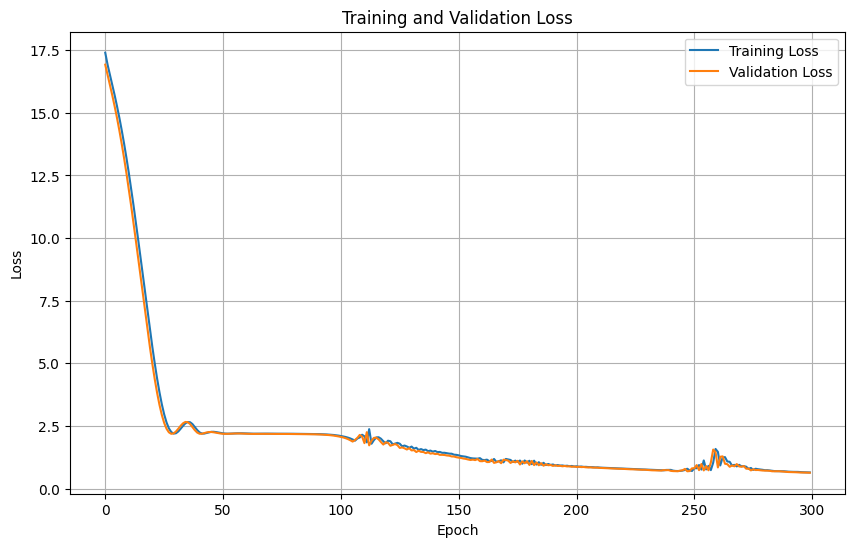

In [37]:
plot_loss(train_loss, valid_loss) # base

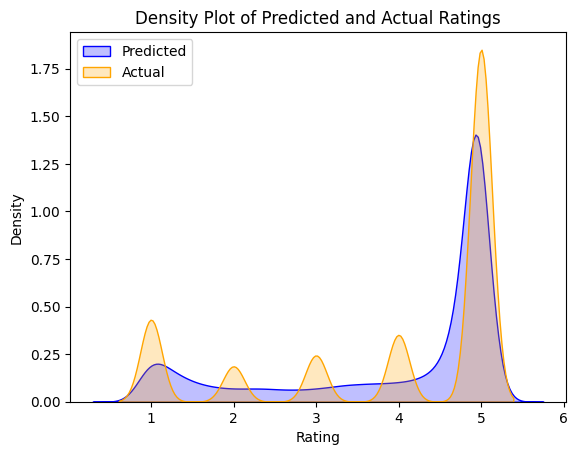

{'Test loss': 0.3558957874774933, 'Best possible loss': 0.3558957874774933}

In [47]:
final_evaluation(base_gnn_model, test_edge_index, test_edge_weights, user_features, product_features, best_model, plot=True)

Test loss: 0.6289


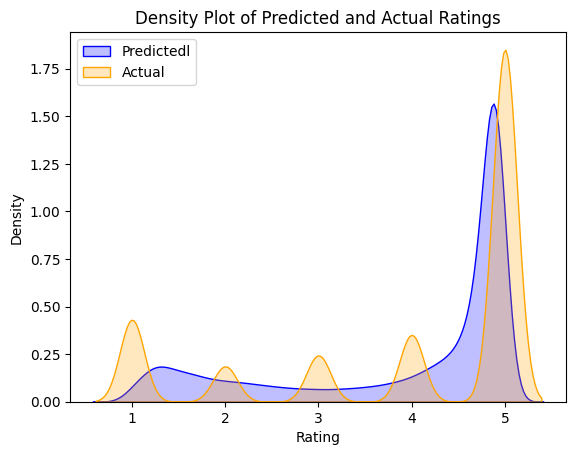

Best possible loss: 0.6289


In [38]:
final_evaluation(base_gnn_model, test_edge_index, test_edge_weights, user_features, product_features, best_model, plot=True)

# Next recomendations 

Based on the current set up, the model predicts the exact same stuff for users

In [48]:
base_gnn_model.load_state_dict(best_model)

<All keys matched successfully>

In [49]:
min_unique_purchase = 10
count_purchase = edge_list_df.groupby("user_id").agg({"parent_asin": "nunique"}).rename(columns = {"parent_asin": "no_of_unique_products_bought"})
dense_user_id = count_purchase[count_purchase["no_of_unique_products_bought"] >= min_unique_purchase].reset_index(drop=False)
print("There are {} users who have bought more than {} items".format(dense_user_id.shape[0], min_unique_purchase))

There are 323 users who have bought more than 10 items


In [586]:
user_id = dense_user_id.user_id.sample(1).item()
# user_id = edge_list_df.user_id.sample(1).item()
print(user_id, "\n")
print("Recommended products", "\n")
recomendations = recommend_products(base_gnn_model, user_id, user_mapping, product_mapping,
                                     user_features, product_features, top_k=10)
pretty_print_recomendations(recomendations[0], product_title_df, "title")
print("\n")
print("Ratings are: ", recomendations[1].numpy())

print("\n")
print("Actual products bought", "\n")
actual_recommendations = edge_list_df.loc[edge_list_df["user_id"] == user_id].parent_asin.to_list()
pretty_print_recomendations(actual_recommendations, product_title_df, "title")
print("\n")
print("Ratings are: ", edge_list_df.loc[(edge_list_df["user_id"]==user_id) & (edge_list_df["parent_asin"].isin(actual_recommendations)), "rating"].to_list())

AF6RTFII4XB2EGU2C3SYBIRGG4VQ 

Recommended products 

Product 1: Perris Monte Carlo Rose De Taif Travel Spray Refill, 2 Count
Product 2: Jordana Matte Lipstick 22 Honey
Product 3: Tarte Face Tape Foundation 35N Medium Neutral - Full Size
Product 4: Con Dtngle Comb Non Stati Size Ea
Product 5: 12 Colors Neutrals Forever Eyeshadow Palette. 100% Authentic by The Princess Stories39
Product 6: John Frieda Frizz Ease KeraFirm Hairspray, Firm Hold 13 oz (Pack of 4)
Product 7: MONAT STYLIZED SYSTEM-REFINISH CONTROL HAIRSPRAY/RESTYLE INSTANT SCULPTING TAFFY/TOUSLED TEXTURIZING MIST
Product 8: Pretty Peepers, Collagen Enriched Eye Pads with Hyaluronic Acid & Homostatin, By Diva Stuff
Product 9: Fright Night Cosmetics Claw Polish - Ghostest with The Mostest (Top Coat, 0.5oz)
Product 10: Finesse Sham Clr Vital Size 13.Z


Ratings are:  [4.3243837 4.323618  4.3228226 4.322225  4.3220887 4.321482  4.321476
 4.321371  4.321072  4.3201084]


Actual products bought 

Product 1: 100% Human Hair Dreadloc

# Model tuning and diagnostics

## 1. Understand why model is producing constant rating output
Our new BaseGNN model is achieving pretty good test MSE score. However, it is always recommending the same products.
Here, we seek to understand why this is the case and make potential amendments.

#### Plot activation outputs through GNN architecture
Visualizing acitivation outputs yield interesting results. We visualize the activation outputs in reversed order, in order to get intuition of why we are getting constant ratings for all users. Key observations as follows:
- In the final conv2 activation output, we see that user embeddings have much greater heterogeneity (first ~600,000 rows) compared to product embeddings (latter ~80,000 rows). The homogeneity of product embeddings explains why we are producing constant recommendations regardless of selected user, since the baseGNN model now uses dot product of user embeddings and product embeddings (with some MLP layers) to get ratings. Let's try to figure out why we are not learning effective embeddings for products by visualizing earlier layers. Two hypotheses: (i) Our product feature inputs are not meaningful (ii) Our GNN architecture is "smoothing" out product embeddings too much from the GCN Conv layers, which essentially combines one's existing embeddings and neighbour's embeddings to form new set of embeddings.
- In conv1 activation output, we see some degree of heterogeneity in the product embeddings, though still relatively homogenous. I guess we cannot ascertain whether hypotheses (i) or (ii) is causing this, but what it does confirm is that GCNConv does cause a smoothing effect.
- In product_feature_transform output, we see even more heterogeneity in product features. That said, it still has less variance compared to user_feature_transform activation output.

Hypotheses:
- 1/ One suspicion is that our product-level review embeddings are not meaningful. We can verify this by initializing random product-level review embeddings to see how well the model trains. This is tackled in section (2) of diagnostic tests.
- 2/ Another hypotheses is we are washing out product-level signals with our GNN architecture. We can try changing the architecture to better capture embedding characteristics. This is tackled in section (3) of diagnostic tests.

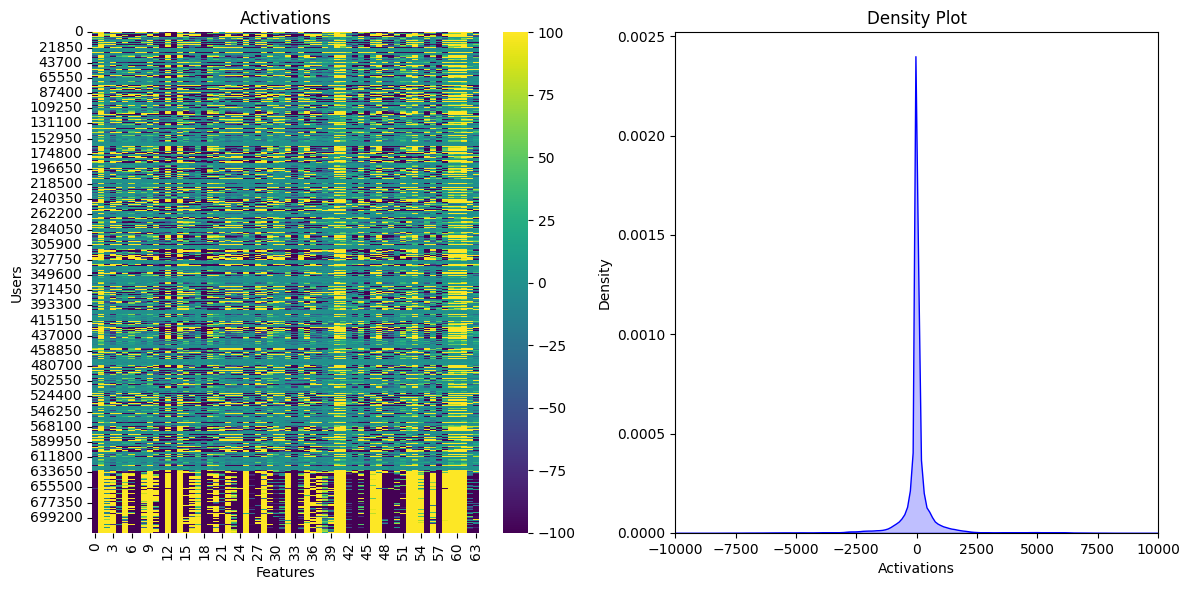

In [595]:
# Visualize activations of conv2 activation output
activations_of_interest = activations[base_gnn_model.conv2].detach().numpy()
plot_activation_heatmap_and_density(activations_of_interest)

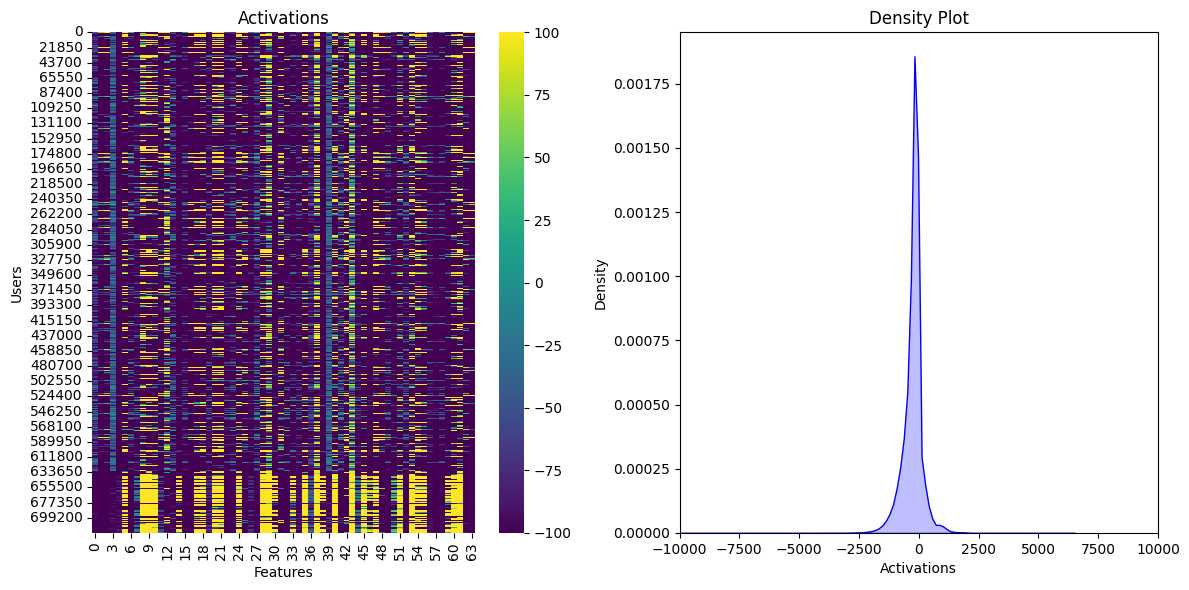

In [599]:
# Visualize activations of conv1 activation output
activations_of_interest = activations[base_gnn_model.conv1].detach().numpy()
plot_activation_heatmap_and_density(activations_of_interest)

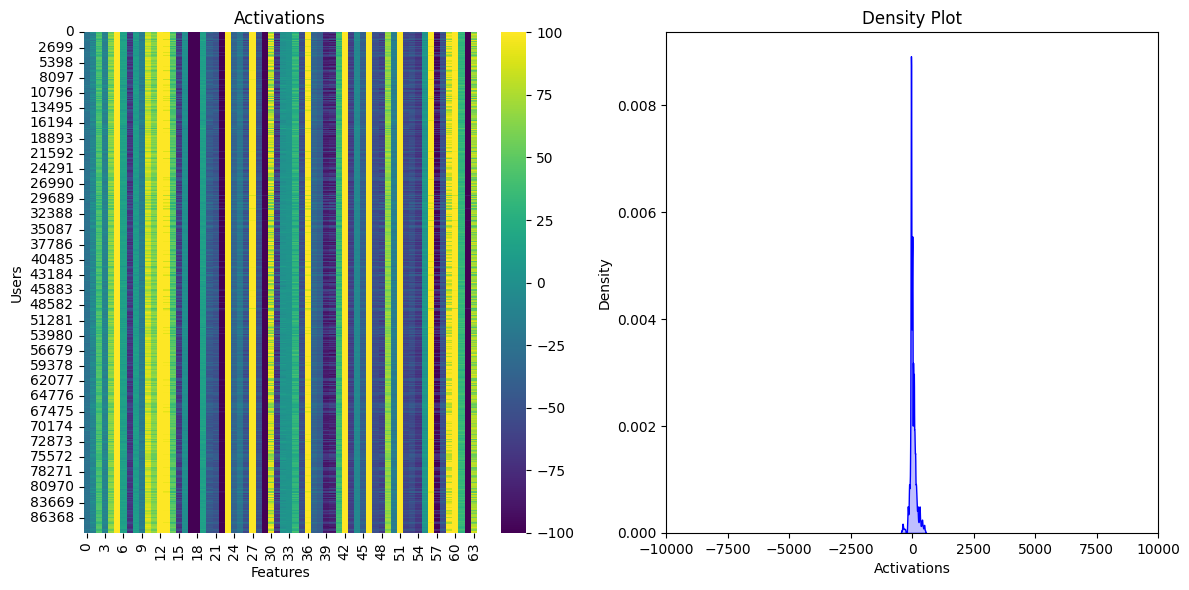

In [600]:
# Visualize activations of product_feature_transform activation output
activations_of_interest = activations[base_gnn_model.product_feature_transform].detach().numpy()
plot_activation_heatmap_and_density(activations_of_interest)

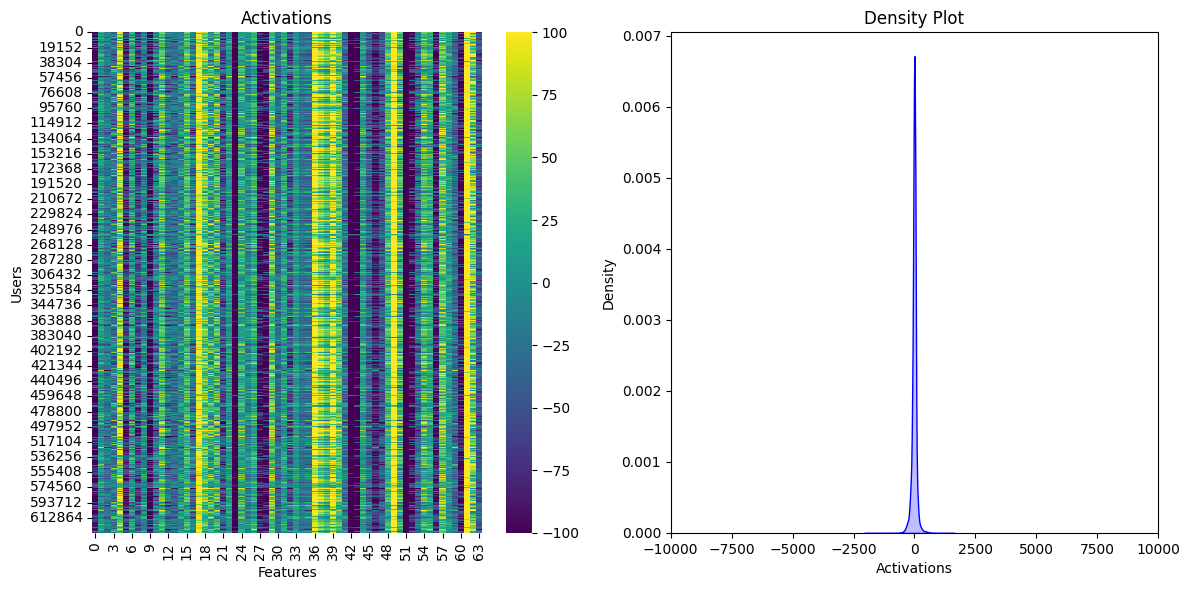

In [601]:
# Visualize activations of user_feature_transform activation output
activations_of_interest = activations[base_gnn_model.user_feature_transform].detach().numpy()
plot_activation_heatmap_and_density(activations_of_interest)

## 2. Test hypothesis (1): Decoupling embedding features by training model with random embeddings
We test out the first hypotheses from (1) (i.e., product features are not meaningful) by training the model with random embeddings. Particularly, since product feature embeddings is the one that seem homogenous, we use random product feature inputs but keeping user feature inputs as is.

To see how useful user and product feature embeddings are, we also initialize the model with random inputs for both user and product feature inputs. That is, we have the following 2 combinations:
- 1/ Random product features, with standard user features >> This tells us how important product features are
- 2/ Random user features, with standard product features >> This tells us how important user features are

In [32]:
# Randomise both user and product features
random_user_features = torch.rand_like(user_features)
random_product_features = torch.rand_like(product_features)

#### A. Randomise product features

Here, we see that even though train and validation loss decreases, this does not transfer well to final evaluation, where the RSME is 2+. This suggests that our product features is capturing meaningful information. In other words, referring back to (1), we need to improve the GNN architecture to enable product feature information to flow through better.

Epoch: 10, Train Loss: 12.3688, Val Loss: 11.4927, best model epoch: 10
Epoch: 20, Train Loss: 3.9487, Val Loss: 3.3421, best model epoch: 20
Epoch: 30, Train Loss: 2.8059, Val Loss: 2.9077, best model epoch: 24
Epoch: 40, Train Loss: 2.2360, Val Loss: 2.2682, best model epoch: 37
Epoch: 50, Train Loss: 2.1928, Val Loss: 2.1875, best model epoch: 49
Epoch: 60, Train Loss: 2.1966, Val Loss: 2.1852, best model epoch: 49
Epoch: 70, Train Loss: 2.1941, Val Loss: 2.1846, best model epoch: 61
Epoch: 80, Train Loss: 2.1931, Val Loss: 2.1843, best model epoch: 72
Epoch: 90, Train Loss: 2.1907, Val Loss: 2.1821, best model epoch: 90
Epoch: 100, Train Loss: 2.1852, Val Loss: 2.1755, best model epoch: 100
Epoch: 110, Train Loss: 2.1617, Val Loss: 2.1449, best model epoch: 110
Epoch: 120, Train Loss: 2.0201, Val Loss: 1.9452, best model epoch: 120
Epoch: 130, Train Loss: 2.0403, Val Loss: 1.7567, best model epoch: 130
Epoch: 140, Train Loss: 1.7401, Val Loss: 1.5748, best model epoch: 140
Epoch: 1

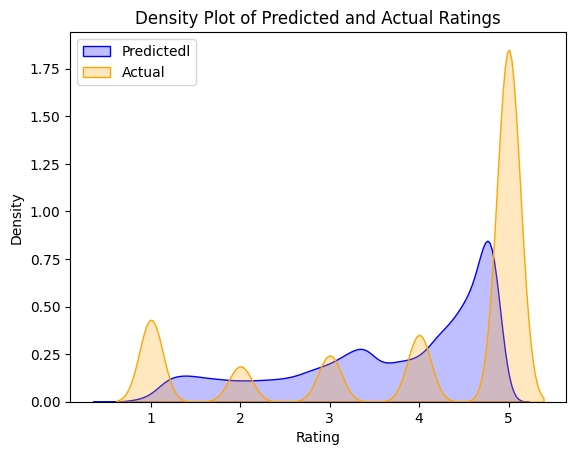

Best possible loss: 2.2011


In [33]:
test_base_gnn_model = BaseGNNRecommender(num_users, num_products, user_feature_dim,product_feature_dim, embedding_dim=64)
optimizer = torch.optim.Adam(test_base_gnn_model.parameters(), lr=0.01)
test_base_gnn_model.to(device)
train_loss_random_product, valid_loss_random_product, best_model_random_product = train_model(test_base_gnn_model, train_edge_index, train_edge_weights, val_edge_index, val_edge_weights, 
                                                 user_features, random_product_features, num_epochs = 300, print_progress=True)
final_evaluation(test_base_gnn_model, test_edge_index, test_edge_weights, user_features, random_product_features, best_model_random_user, plot=True)

#### B. Randomise user features

We show here that with randomised user features, the model performs poorly. The model essentially outputs rating of 4 for every product. This also achieves a high loss of 2+.
This validates what we saw in diagnostic test (1), where we see high degree of heterogeneity in user feature embeddings. This section validates that this heterogeneity is not random, but are meaningful differences.

Epoch: 10, Train Loss: 13.4900, Val Loss: 12.7392, best model epoch: 10
Epoch: 20, Train Loss: 5.6454, Val Loss: 4.8993, best model epoch: 20
Epoch: 30, Train Loss: 2.2788, Val Loss: 2.4063, best model epoch: 27
Epoch: 40, Train Loss: 2.2261, Val Loss: 2.1846, best model epoch: 40
Epoch: 50, Train Loss: 2.2096, Val Loss: 2.1889, best model epoch: 40
Epoch: 60, Train Loss: 2.2101, Val Loss: 2.1958, best model epoch: 51
Epoch: 70, Train Loss: 2.1997, Val Loss: 2.1911, best model epoch: 51
Epoch: 80, Train Loss: 2.1938, Val Loss: 2.1860, best model epoch: 76
Epoch: 90, Train Loss: 2.1927, Val Loss: 2.1845, best model epoch: 88
Epoch: 100, Train Loss: 2.1926, Val Loss: 2.1843, best model epoch: 100
Epoch: 110, Train Loss: 2.1926, Val Loss: 2.1843, best model epoch: 100
Epoch: 120, Train Loss: 2.1926, Val Loss: 2.1843, best model epoch: 111
Epoch: 130, Train Loss: 2.1925, Val Loss: 2.1843, best model epoch: 130
Epoch: 140, Train Loss: 2.1926, Val Loss: 2.1843, best model epoch: 140
Epoch: 1

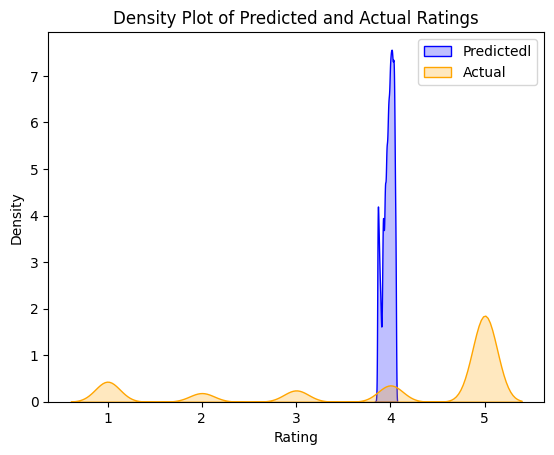

Best possible loss: 2.1864


In [32]:
test_base_gnn_model = BaseGNNRecommender(num_users, num_products, user_feature_dim,product_feature_dim, embedding_dim=64)
optimizer = torch.optim.Adam(test_base_gnn_model.parameters(), lr=0.01)
test_base_gnn_model.to(device)
train_loss_random_user, valid_loss_random_user, best_model_random_user = train_model(test_base_gnn_model, train_edge_index, train_edge_weights, val_edge_index, val_edge_weights, 
                                                 random_user_features, product_features, num_epochs = 300, print_progress=True)
final_evaluation(test_base_gnn_model, test_edge_index, test_edge_weights, random_user_features, product_features, best_model_random_user, plot=True)

## 3. Test hypothesis (2): Improvements to GNN architecture

The above section disproved hypotheses (1) which claims that embeddings are not meaningful, so we proceed with hypotheses (2). i.e., let's try to improve the GNN architecture so that it better passes through information on products. To do this, we add skip connections, which should in theory help to preserve information from original input that could be washed out by the GCNConv layers. After trying out skip connections only, I found more diverse activation embeddings for products, but still getting same recommendations for everyone. Hence, I've also added BatchNorm layers as without that, activation output are very large (which would likely cause overfitting). Another change that I made is to reduce the predictor layer to a single feedforward layer. This helps provide better intuition on how the model works by allowing us to see weights of that layer, and also prevent overfitting on the dot product of user and product embeddings.

These changes are implemented in the new architecture: GNNRecommenderwithSkipConnections. To summarise, there are 3 changes from the BaseGNNRecomender:
- Added skip connections
- Added batch norm layers
- Simplified MLP predictor to single feedforward layer

In [ ]:
# GNN with skip connections
gnn_with_skip_connections_model = GNNRecommenderwithSkipConnections(num_users, num_products, user_feature_dim,product_feature_dim, embedding_dim=64)
optimizer = torch.optim.Adam(gnn_with_skip_connections_model.parameters(), lr=0.01)

In [211]:
# Record activations for visualization
activations = {}  # Dictionary to store activations
gnn_with_skip_connections_model.conv1.register_forward_hook(hook_fn)
gnn_with_skip_connections_model.conv2.register_forward_hook(hook_fn)
gnn_with_skip_connections_model.user_feature_transform.register_forward_hook(hook_fn)
gnn_with_skip_connections_model.product_feature_transform.register_forward_hook(hook_fn)

In [36]:
gnn_with_skip_connections_model.to(device)
gnn_skip_connections_train_loss, gnn_skip_connections_valid_loss, best_gnn_skip_connections_model = train_model(gnn_with_skip_connections_model, train_edge_index, train_edge_weights, val_edge_index, val_edge_weights, 
                                                 user_features, product_features, num_epochs = 300, print_progress=True)

Epoch: 10, Train Loss: 16.7467, Val Loss: 16.5827, best model epoch: 10
Epoch: 20, Train Loss: 15.1205, Val Loss: 14.9704, best model epoch: 20
Epoch: 30, Train Loss: 13.6072, Val Loss: 13.4650, best model epoch: 30
Epoch: 40, Train Loss: 12.1835, Val Loss: 12.0460, best model epoch: 40
Epoch: 50, Train Loss: 10.8415, Val Loss: 10.7106, best model epoch: 50
Epoch: 60, Train Loss: 9.5617, Val Loss: 9.4332, best model epoch: 60
Epoch: 70, Train Loss: 8.3637, Val Loss: 8.2451, best model epoch: 70
Epoch: 80, Train Loss: 7.2846, Val Loss: 7.1790, best model epoch: 80
Epoch: 90, Train Loss: 6.3223, Val Loss: 6.2294, best model epoch: 90
Epoch: 100, Train Loss: 5.4824, Val Loss: 5.4044, best model epoch: 100
Epoch: 110, Train Loss: 4.7701, Val Loss: 4.7023, best model epoch: 110
Epoch: 120, Train Loss: 4.1734, Val Loss: 4.1171, best model epoch: 120
Epoch: 130, Train Loss: 3.6929, Val Loss: 3.6469, best model epoch: 130
Epoch: 140, Train Loss: 3.3173, Val Loss: 3.2805, best model epoch: 140


##### Seems like 300 epoch is not enough, let's train for another 300...

In [37]:
gnn_skip_connections_train_loss, gnn_skip_connections_valid_loss, best_gnn_skip_connections_model = train_model(gnn_with_skip_connections_model, train_edge_index, train_edge_weights, val_edge_index, val_edge_weights, 
                                                 user_features, product_features, num_epochs = 300, print_progress=True)

Epoch: 10, Train Loss: 1.3953, Val Loss: 1.3918, best model epoch: 10
Epoch: 20, Train Loss: 1.2000, Val Loss: 1.1799, best model epoch: 20
Epoch: 30, Train Loss: 1.0657, Val Loss: 1.0551, best model epoch: 30
Epoch: 40, Train Loss: 0.9643, Val Loss: 0.9584, best model epoch: 40
Epoch: 50, Train Loss: 0.8873, Val Loss: 0.8837, best model epoch: 50
Epoch: 60, Train Loss: 0.8264, Val Loss: 0.8271, best model epoch: 60
Epoch: 70, Train Loss: 0.7818, Val Loss: 0.7880, best model epoch: 70
Epoch: 80, Train Loss: 0.7380, Val Loss: 0.7522, best model epoch: 79
Epoch: 90, Train Loss: 0.7237, Val Loss: 0.7123, best model epoch: 90
Epoch: 100, Train Loss: 0.6811, Val Loss: 0.6801, best model epoch: 100
Epoch: 110, Train Loss: 0.6202, Val Loss: 0.6296, best model epoch: 110
Epoch: 120, Train Loss: 0.7160, Val Loss: 0.6387, best model epoch: 110
Epoch: 130, Train Loss: 0.6133, Val Loss: 0.6347, best model epoch: 127
Epoch: 140, Train Loss: 0.5576, Val Loss: 0.5795, best model epoch: 139
Epoch: 150

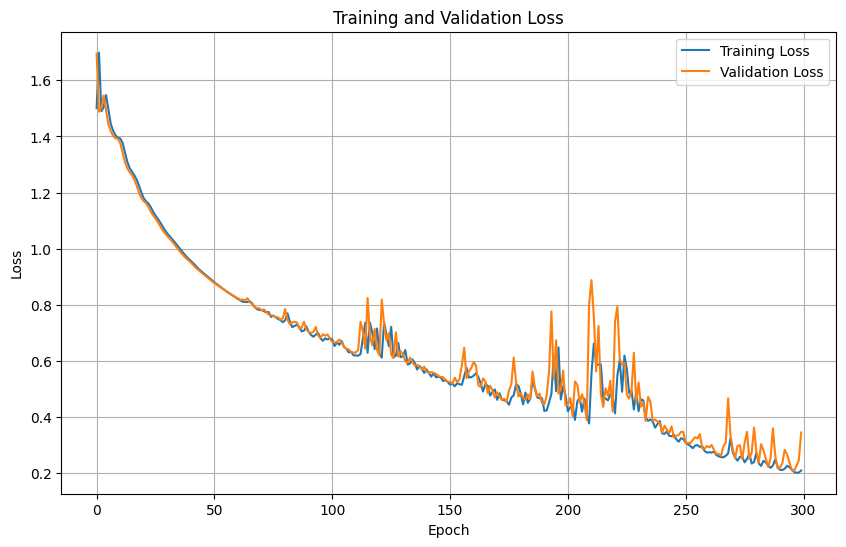

In [38]:
plot_loss(gnn_skip_connections_train_loss, gnn_skip_connections_valid_loss)

Test loss: 0.3455


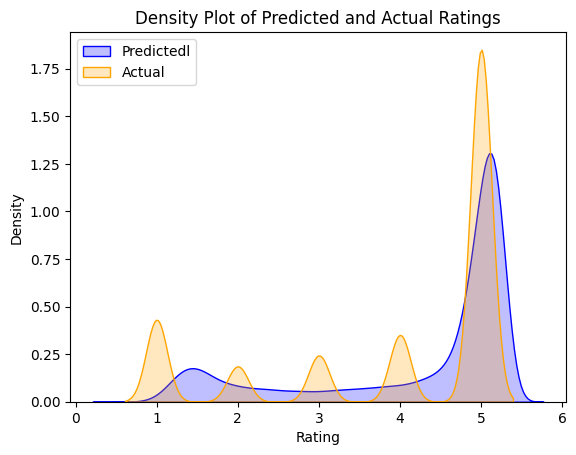

Best possible loss: 0.2131


In [39]:
final_evaluation(gnn_with_skip_connections_model, test_edge_index, test_edge_weights, user_features, product_features, best_gnn_skip_connections_model, plot=True)

##### We see above that model trains much better with skip connections and we attain lower loss in final evaluation

##### Now, let's see if the recommendations are still the same regardless of user.

It actually (somewhat) works now! If we sample from users who purchase more than 10 products, we get different predictions for different users.
On the other hand, if we sample from users who maybe only bought 1 product, the recommendations we get are more or less similar.
This somewhat aligns with intuition since we know more about users who have bought more products, while for users on whom we have little information, we want to recommend the most popular products.
(Note: I actually tried traininig for longer as well and managed to get test loss down to ~0.15. But recommendations made for different users would be the same.)

In [215]:
gnn_with_skip_connections_model.load_state_dict(best_gnn_skip_connections_model)

<All keys matched successfully>

In [144]:
for i in range(2):
    print(f"USER {i+1}")
    
    user_id = dense_user_id.user_id.sample(1).item()
    # user_id = edge_list_df.user_id.sample(1).item()
    print(user_id, "\n")
    print("Recommended products", "\n")
    recomendations = recommend_products(gnn_with_skip_connections_model, user_id, user_mapping, product_mapping,
                                         user_features, product_features, top_k=10)
    pretty_print_recomendations(recomendations[0], product_title_df, "title")
    print("\n")
    print("Ratings are: ", recomendations[1].numpy())
    
    print("\n")
    print("Actual products bought", "\n")
    actual_recommendations = edge_list_df.loc[edge_list_df["user_id"] == user_id].parent_asin.to_list()
    pretty_print_recomendations(actual_recommendations, product_title_df, "title")
    print("\n")
    print("Ratings are: ", edge_list_df.loc[(edge_list_df["user_id"]==user_id) & (edge_list_df["parent_asin"].isin(actual_recommendations)), "rating"].to_list())
    print("\n")
    print("\n")

USER 1
AHSIR56YDJL76VXSFEKI5YQPYJ2Q 

Recommended products 

Product 1: DIFEI Outdoor Hat Wig Patients Hat with Hair for Women Chemical Treatment Baseball Cap Hat with Wig Attached Synthetic Hair Wig (Cap Wig)
Product 2: The Wet Brush Brush Holder
Product 3: Hair Ring Styler Maker Creator Hot Wig Hair Donut Bun Maker Updo Scrunchie Chignon Bridal Hairpiece Bun Round Chignon for Women Lady Girls (Red Brown)
Product 4: 4 Pieces Glass Nail Shiner Crystal Nail Shine Buffer Polisher Crystal Glass Nano Nail File with Case for Natural Nails (Black Flat End)
Product 5: gdfh Makeup Brush Foundation Brushes Flat Top Brushes Full Coverage Concealer Buffer Brush Contour Brush Face Powder Brush
Product 6: BOGSEA Bangs Hair Clip in Bangs Real Human Hair Wispy Bangs Fringe with Temples Hairpieces for Women Clip on Air Bangs Flat Neat Bangs Hair Extension for Daily Wear (Dark Blonde).
Product 7: Green Tea Stick Mask,Purifying Clay Mask,Charcoal Glowing Mask,Oil Control Face Mask,Facial Mask Stick,Deep

##### Why is this working now? Let's visualise the activation output for conv2 to see if they are still as homogenous for products

While product embeddings (bottom rows) are still more homogenous than user embeddings (top rows), we can now observe more subtle variations in the shades compared to before and they are also less extreme values

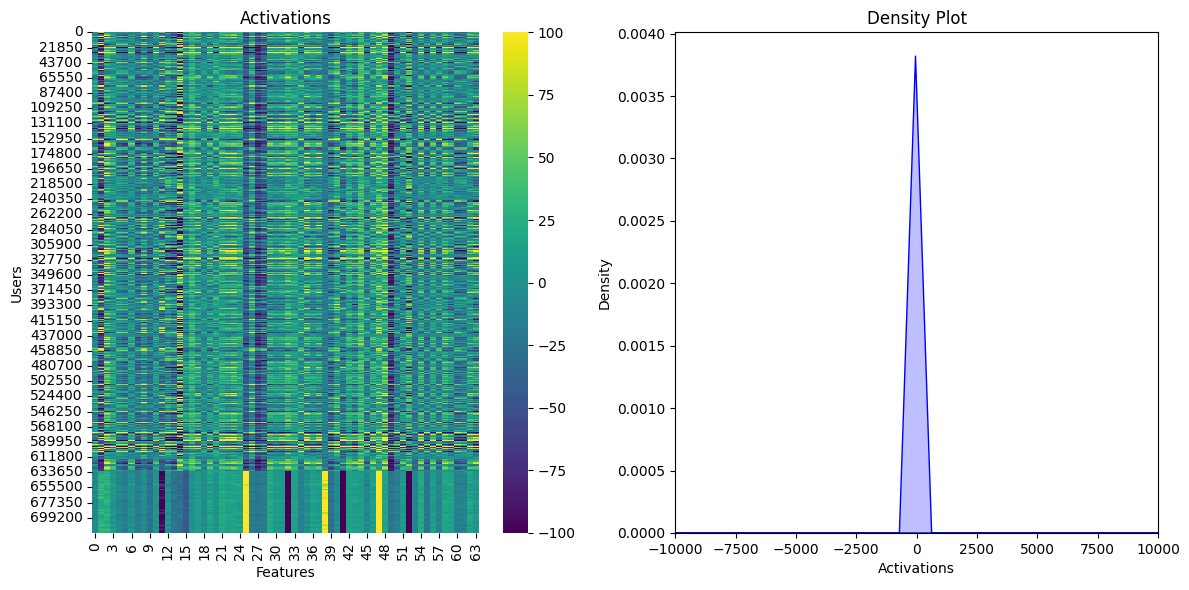

In [79]:
# Visualize activations of conv2 activation output
activations_of_interest = activations[gnn_with_skip_connections_model.conv2].detach().numpy()
plot_activation_heatmap_and_density(activations_of_interest)

##### Here, we also visualise model weights. Particularly, pay attention to predictor.weight, of which non-zero weights show that the model is taking in meaningful inputs from the GCNConv layers

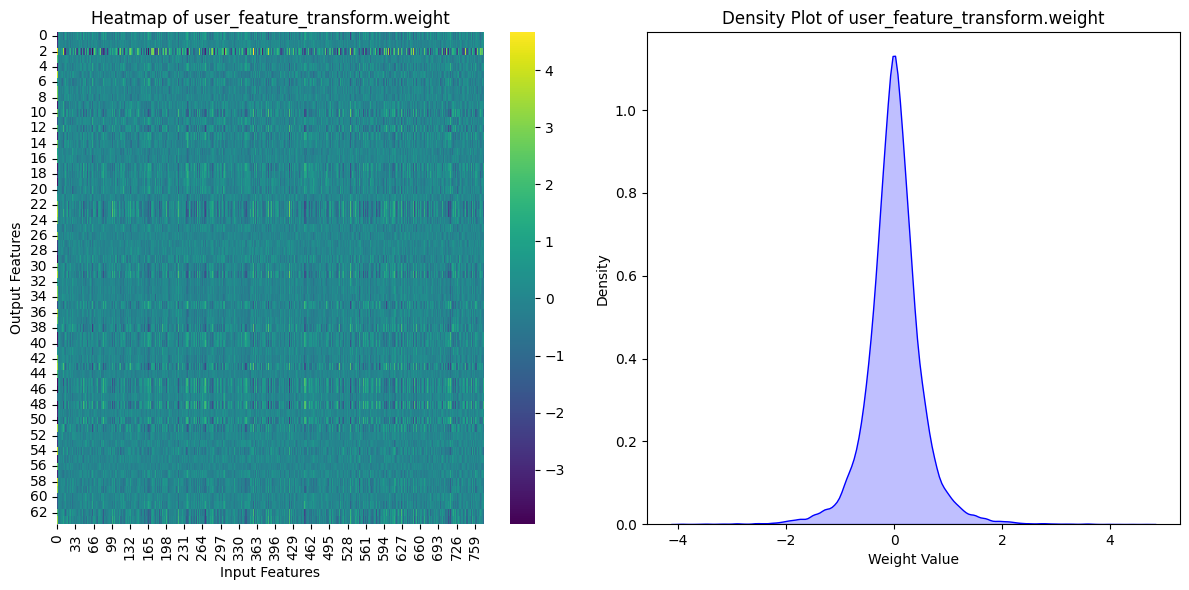

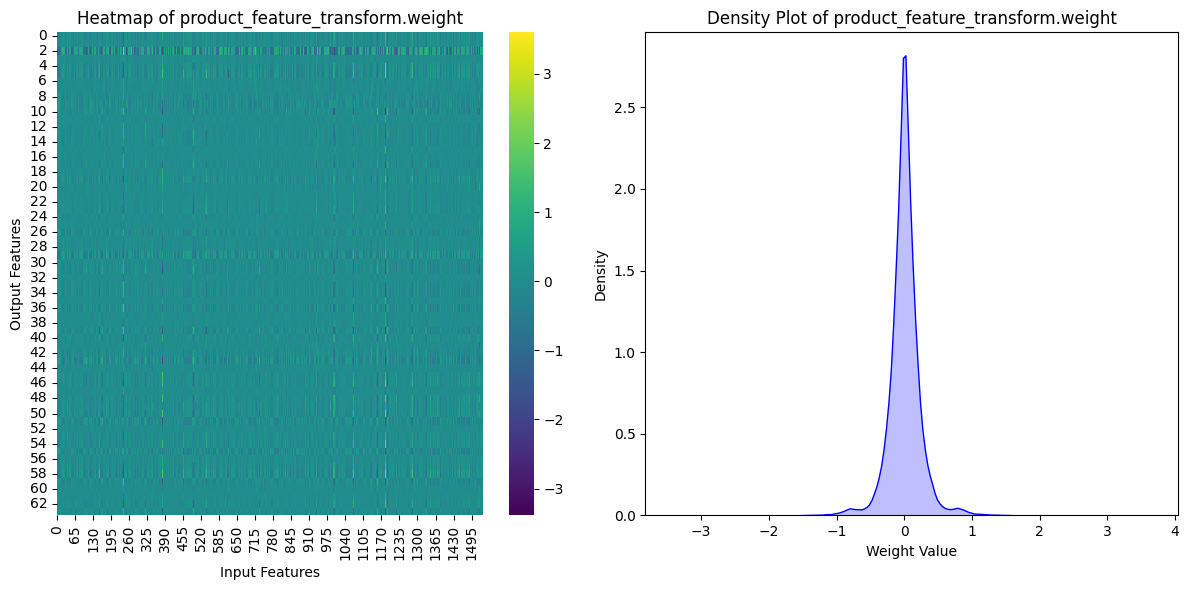

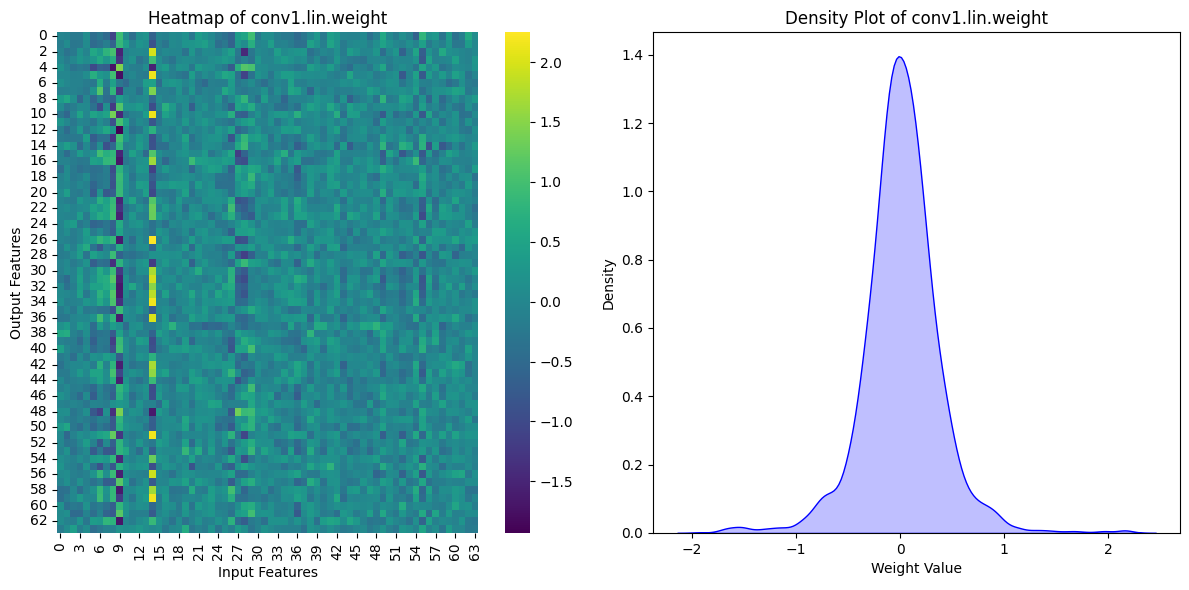

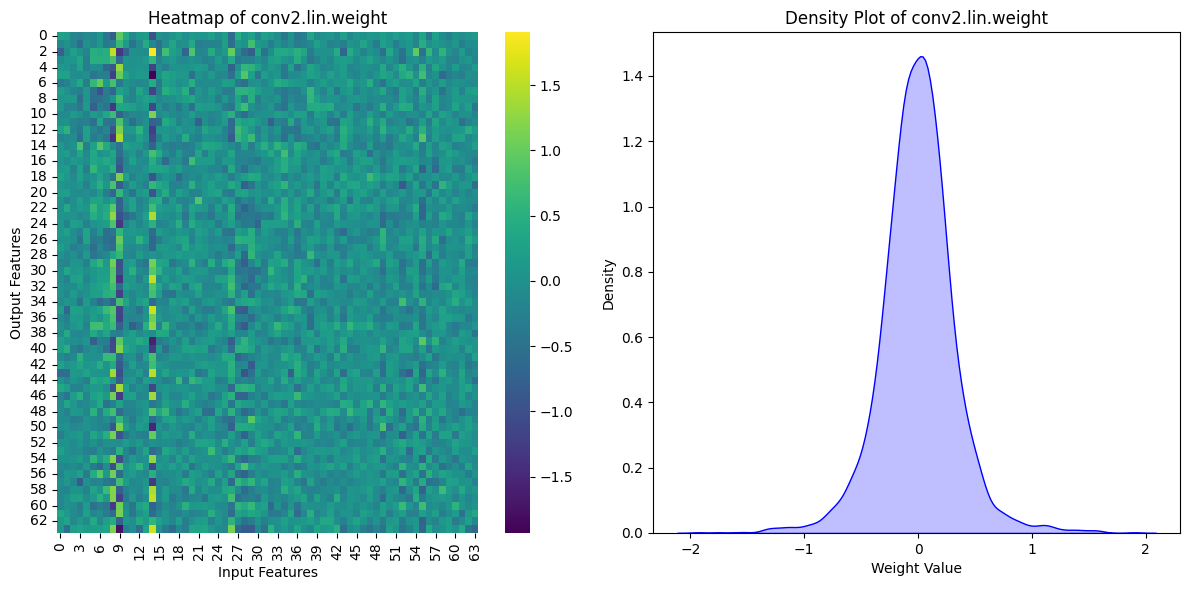

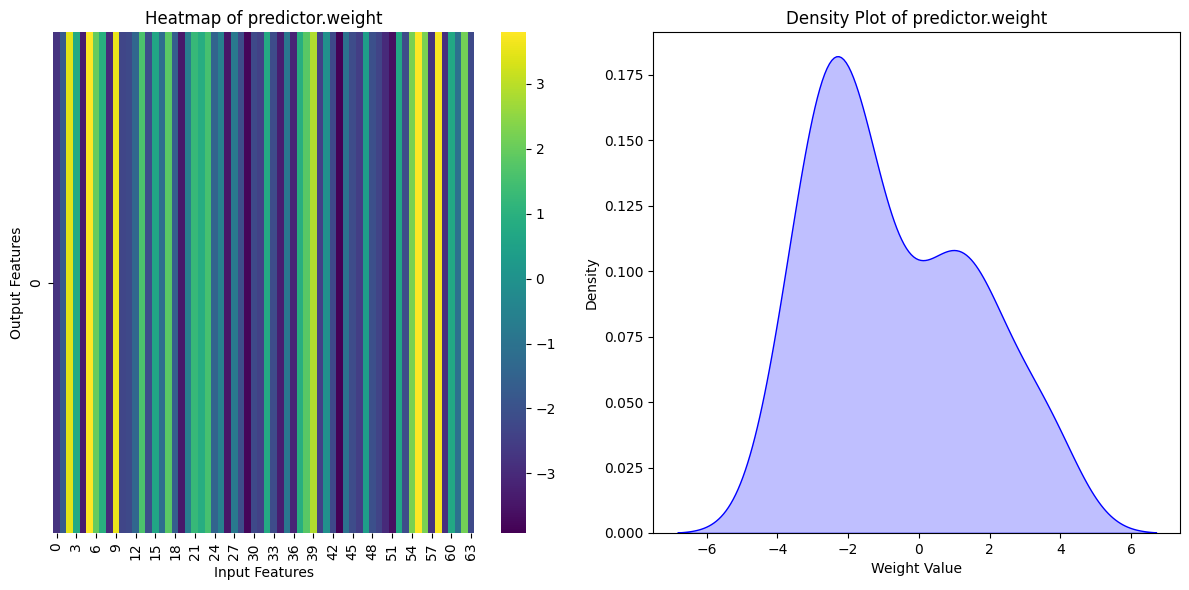

In [83]:
# Visualise model weights
for attribute_key in best_gnn_skip_connections_model.keys():
    if "weight" in attribute_key and "bn" not in attribute_key:
        weights = best_gnn_skip_connections_model[attribute_key].numpy()
        plot_weights_heatmap_and_density(weights, attribute_key)

## 4. Hyperparameter tuning

Now that we have implemented improvements to the GNN architecture, it's time to search for optimal hyperparameters.

In [316]:
# Define dictionary for fixed inputs
fixed_inputs = {
    "num_users": num_users,
    "num_products": num_products,
    "user_feature_dim": user_feature_dim,
    "product_feature_dim": product_feature_dim,
    "train_edge_index": train_edge_index,
    "train_edge_weights": train_edge_weights,
    "val_edge_index": val_edge_index,
    "val_edge_weights": val_edge_weights,
    "test_edge_index": test_edge_index,
    "test_edge_weights": test_edge_weights,
    "user_features": user_features,
    "product_features": product_features,
    "device": device
}

### A. Grid search for GNNRecommenderWithSkipConnections

In [304]:
# Define the hyperparameters as a dictionary
hyperparameters_basegnn_skip = {
    "embedding_dim": [32, 64, 128, 256],
    "learning_rate": [0.01, 0.05, 0.1],
    "num_epochs": [500],
}
hyperparameters_basegnn_skip_df = make_hyperparameters_grid(hyperparameters_basegnn_skip)
hyperparameters_basegnn_skip_df = grid_search_hyperparameters(hyperparameters_basegnn_skip_df, GNNRecommenderwithSkipConnections, **fixed_inputs, save_interim=False)

Running results for 1 out of 12...
Running results for 2 out of 12...
Running results for 3 out of 12...
Running results for 4 out of 12...
Running results for 5 out of 12...
Running results for 6 out of 12...
Running results for 7 out of 12...
Running results for 8 out of 12...
Running results for 9 out of 12...
Running results for 10 out of 12...
Running results for 11 out of 12...
Running results for 12 out of 12...


In [280]:
hyperparameters_basegnn_skip_df

,embedding_dim,learning_rate,num_epochs,train_loss,valid_loss,test_loss,best_possible_loss
0,32,0.01,500,"[19.1908016204834, 18.671010971069336, 18.3784...","[18.96428871154785, 18.374177932739258, 18.117...",0.398914,0.398914
1,32,0.05,500,"[18.978776931762695, 18.512277603149414, 18.21...","[18.83142852783203, 18.21021842956543, 17.9051...",0.410499,0.389902
2,32,0.10,500,"[18.708446502685547, 18.167892456054688, 17.91...","[18.277587890625, 17.9925594329834, 17.7762088...",0.587900,0.485785
3,64,0.01,500,"[17.849395751953125, 17.329248428344727, 17.10...","[17.435808181762695, 17.168983459472656, 16.92...",0.359943,0.359943
4,64,0.05,500,"[17.79615020751953, 17.414398193359375, 17.215...","[17.706933975219727, 17.290494918823242, 17.07...",0.389852,0.389852
5,64,0.10,500,"[17.19182586669922, 16.832317352294922, 16.619...","[16.723243713378906, 16.69782829284668, 16.491...",0.398865,0.398865
6,128,0.01,500,"[18.099609375, 17.770265579223633, 17.57302093...","[17.905052185058594, 17.634756088256836, 17.40...",0.467117,0.404046
7,128,0.05,500,"[17.564302444458008, 17.258258819580078, 17.03...","[17.358917236328125, 17.085824966430664, 16.87...",0.433903,0.406071
8,128,0.10,500,"[17.700584411621094, 17.396137237548828, 17.20...","[17.516199111938477, 17.260892868041992, 17.04...",0.455422,0.370344
9,256,0.01,500,"[18.048946380615234, 17.802690505981445, 17.62...","[17.909849166870117, 17.658493041992188, 17.47...",0.475548,0.378711


In [301]:
optimal_hyperparameters_basegnn_skip = hyperparameters_basegnn_skip_df[hyperparameters_basegnn_skip_df['test_loss'] == hyperparameters_basegnn_skip_df['test_loss'].min()]
print(f"Optimal hyperparameters are embedding dimensions: {optimal_hyperparameters_basegnn_skip.embedding_dim.values[0]} and learning rate: {optimal_hyperparameters_basegnn_skip.learning_rate.values[0]}.")

Optimal hyperparameters are embedding dimensions: 64 and learning rate: 0.01.


### B. Grid search for GNNSAGERecommenderWithSkipConnections

In [339]:
# Define the hyperparameters as a dictionary
hyperparameters_gnnsage_skip = {
    "embedding_dim": [32, 64, 128, 256],
    "learning_rate": [0.01, 0.05, 0.1],
    "num_epochs": [500],
}
hyperparameters_gnnsage_skip_df = make_hyperparameters_grid(hyperparameters_gnnsage_skip)
hyperparameters_gnnsage_skip_df = grid_search_hyperparameters(hyperparameters_gnnsage_skip_df, GNNSAGERecommenderwithSkipConnections, **fixed_inputs, save_interim=True)

Running results for 1 out of 12...
Running results for 2 out of 12...
Running results for 3 out of 12...
Running results for 4 out of 12...
Running results for 5 out of 12...
Running results for 6 out of 12...
Running results for 7 out of 12...
Running results for 8 out of 12...
Running results for 9 out of 12...
Running results for 10 out of 12...
Running results for 11 out of 12...
Running results for 12 out of 12...


In [346]:
hyperparameters_gnnsage_skip_df

,Unnamed: 0,embedding_dim,learning_rate,num_epochs,train_loss,valid_loss,test_loss,best_possible_loss
0,0,32,0.01,500,"[19.50823974609375, 18.755794525146484, 18.436...","[18.80535316467285, 18.456579208374023, 18.167...",0.663893,0.301912
1,1,32,0.05,500,"[17.27167510986328, 16.457199096679688, 16.214...","[16.472204208374023, 16.25335121154785, 16.038...",0.368259,0.368259
2,2,32,0.10,500,"[18.883899688720703, 18.36678695678711, 18.050...","[18.40458869934082, 18.036048889160156, 17.794...",0.407729,0.326448
3,3,64,0.01,500,"[17.311443328857422, 16.823978424072266, 16.58...","[16.812946319580078, 16.57453155517578, 16.384...",0.229781,0.229781
4,4,64,0.05,500,"[17.626150131225586, 17.20840835571289, 16.980...","[17.221975326538086, 16.989925384521484, 16.78...",0.398490,0.257540
5,5,64,0.10,500,"[17.248882293701172, 16.878286361694336, 16.66...","[17.087289810180664, 16.674728393554688, 16.47...",0.402914,0.288807
6,6,128,0.01,500,"[17.619239807128906, 17.27615737915039, 17.074...","[17.259294509887695, 17.096290588378906, 16.90...",0.268503,0.242953
7,7,128,0.05,500,"[18.654726028442383, 18.31196403503418, 18.092...","[18.356632232666016, 18.104238510131836, 17.90...",0.295584,0.235314
8,8,128,0.10,500,"[17.757610321044922, 17.41053009033203, 17.188...","[17.457115173339844, 17.214548110961914, 17.01...",0.300084,0.264820
9,9,256,0.01,500,"[17.75170135498047, 17.495622634887695, 17.297...","[17.579383850097656, 17.311275482177734, 17.13...",0.245837,0.230115


In [347]:
optimal_hyperparameters_gnnsage_skip = hyperparameters_gnnsage_skip_df[hyperparameters_gnnsage_skip_df['test_loss'] == hyperparameters_gnnsage_skip_df['test_loss'].min()]
print(f"Optimal hyperparameters are embedding dimensions: {optimal_hyperparameters_gnnsage_skip.embedding_dim.values[0]} and learning rate: {optimal_hyperparameters_gnnsage_skip.learning_rate.values[0]}.")

Optimal hyperparameters are embedding dimensions: 64 and learning rate: 0.01.


# Final training for models with optimal hyperparameters

In [43]:
# Retrain Base GNN
base_gnn_model.to(device)
train_loss, valid_loss, best_model = train_model(base_gnn_model, train_edge_index, train_edge_weights, val_edge_index, val_edge_weights, 
                                                 user_features, product_features, num_epochs = 500, print_progress=True)
# torch.save(best_model, 'models/base_gnn_model.pth')


Epoch: 10, Train Loss: 12.2680, Val Loss: 11.3602, best model epoch: 10
Epoch: 20, Train Loss: 3.8326, Val Loss: 3.2460, best model epoch: 20
Epoch: 30, Train Loss: 2.8147, Val Loss: 2.9113, best model epoch: 24
Epoch: 40, Train Loss: 2.2841, Val Loss: 2.3012, best model epoch: 37
Epoch: 50, Train Loss: 2.1991, Val Loss: 2.1981, best model epoch: 37
Epoch: 60, Train Loss: 2.1926, Val Loss: 2.1852, best model epoch: 59
Epoch: 70, Train Loss: 2.1912, Val Loss: 2.1833, best model epoch: 69
Epoch: 80, Train Loss: 2.1894, Val Loss: 2.1804, best model epoch: 80
Epoch: 90, Train Loss: 2.1790, Val Loss: 2.1676, best model epoch: 90
Epoch: 100, Train Loss: 2.1194, Val Loss: 2.0887, best model epoch: 100
Epoch: 110, Train Loss: 2.0953, Val Loss: 1.9547, best model epoch: 106
Epoch: 120, Train Loss: 1.7482, Val Loss: 1.6013, best model epoch: 118
Epoch: 130, Train Loss: 1.7240, Val Loss: 1.4428, best model epoch: 126
Epoch: 140, Train Loss: 1.4629, Val Loss: 1.3067, best model epoch: 140
Epoch: 

In [41]:
# Retrain Base GNN with Skip Connections with optimal hyperparameters
gnn_with_skip_connections_model = GNNRecommenderwithSkipConnections(num_users, num_products, user_feature_dim,product_feature_dim, embedding_dim=64)
optimizer = torch.optim.Adam(gnn_with_skip_connections_model.parameters(), lr=0.01)
gnn_with_skip_connections_model.to(device)
gnn_skip_connections_train_loss, gnn_skip_connections_valid_loss, best_gnn_skip_connections_model = train_model(gnn_with_skip_connections_model, train_edge_index, train_edge_weights, val_edge_index, val_edge_weights, 
                                                 user_features, product_features, num_epochs = 500, print_progress=True)
# torch.save(best_gnn_skip_connections_model, 'models/gnn_with_skip_connections_model.pth')

Epoch: 10, Train Loss: 15.6648, Val Loss: 15.5128, best model epoch: 10
Epoch: 20, Train Loss: 14.0994, Val Loss: 13.9585, best model epoch: 20
Epoch: 30, Train Loss: 12.6565, Val Loss: 12.5198, best model epoch: 30
Epoch: 40, Train Loss: 11.2927, Val Loss: 11.1625, best model epoch: 40
Epoch: 50, Train Loss: 10.0099, Val Loss: 9.8795, best model epoch: 50
Epoch: 60, Train Loss: 8.7997, Val Loss: 8.6798, best model epoch: 60
Epoch: 70, Train Loss: 7.6783, Val Loss: 7.5716, best model epoch: 70
Epoch: 80, Train Loss: 6.6711, Val Loss: 6.5758, best model epoch: 80
Epoch: 90, Train Loss: 5.7904, Val Loss: 5.7061, best model epoch: 90
Epoch: 100, Train Loss: 5.0224, Val Loss: 4.9479, best model epoch: 100
Epoch: 110, Train Loss: 4.3662, Val Loss: 4.3022, best model epoch: 110
Epoch: 120, Train Loss: 3.8216, Val Loss: 3.7694, best model epoch: 120
Epoch: 130, Train Loss: 3.3960, Val Loss: 3.3551, best model epoch: 130
Epoch: 140, Train Loss: 3.0761, Val Loss: 3.0437, best model epoch: 140
E

In [30]:
# Retrain GNNSAGE with Skip Connections with optimal hyperparameters
gnn_sage_with_skip_connections_model = GNNSAGERecommenderwithSkipConnections(num_users, num_products, user_feature_dim,product_feature_dim, embedding_dim=64)
optimizer = torch.optim.Adam(gnn_sage_with_skip_connections_model.parameters(), lr=0.01)
gnn_sage_with_skip_connections_model.to(device)
gnn_sage_skip_connections_train_loss, gnn_sage_skip_connections_valid_loss, best_gnn_sage_skip_connections_model = train_model(gnn_sage_with_skip_connections_model, train_edge_index, train_edge_weights, val_edge_index, val_edge_weights, 
                                                 user_features, product_features, num_epochs = 500, print_progress=True)
# torch.save(best_gnn_sage_skip_connections_model, 'models/gnn_sage_with_skip_connections_model.pth')

Epoch: 10, Train Loss: 16.8080, Val Loss: 16.6440, best model epoch: 10
Epoch: 20, Train Loss: 15.1721, Val Loss: 15.0266, best model epoch: 20
Epoch: 30, Train Loss: 13.6636, Val Loss: 13.5276, best model epoch: 30
Epoch: 40, Train Loss: 12.2464, Val Loss: 12.1161, best model epoch: 40
Epoch: 50, Train Loss: 10.8970, Val Loss: 10.7729, best model epoch: 50
Epoch: 60, Train Loss: 9.6215, Val Loss: 9.5033, best model epoch: 60
Epoch: 70, Train Loss: 8.4209, Val Loss: 8.3105, best model epoch: 70
Epoch: 80, Train Loss: 7.3218, Val Loss: 7.2224, best model epoch: 80
Epoch: 90, Train Loss: 6.3292, Val Loss: 6.2392, best model epoch: 90
Epoch: 100, Train Loss: 5.4640, Val Loss: 5.3873, best model epoch: 100
Epoch: 110, Train Loss: 4.7499, Val Loss: 4.6874, best model epoch: 110
Epoch: 120, Train Loss: 4.1848, Val Loss: 4.1347, best model epoch: 120
Epoch: 130, Train Loss: 3.7404, Val Loss: 3.6997, best model epoch: 130
Epoch: 140, Train Loss: 3.3883, Val Loss: 3.3549, best model epoch: 140


# NDCG implementation

NDCG function calculation has been implemented and it now works.
To calculate NDCG, we need to batch up inputs if not memory will be exhausted (refer to test_metrics.py for implementation).

While function to calculate NDCG via batching has been implemented, another issue that arose is how can we get the model to make recommendations for all users in the test set, for all products in the test set. To elaborate, we need the model to rate 183485 unique users * 52195 unique products = 9576999575 ratings, which led to memory exhaustion on my Mac (understandably).

This is probably not possible unless we have a lot of compute. I have demonstrated how NDCG can be applied in 2 alternative ways below

#### Alternative 1
Below is a hack/ improper implementation of NDCG to illustrate that the function works. Here we only ask the trained model to predict ratings for the user-product combinations for which a purchase has been made. This is also why we see an artificially inflated NDCG score of close to 1 (since it means we are almost always recommending the same products).

In [44]:
ndcg_scores_base_gnn = calculate_ndcg_scores(base_gnn_model, best_model, test_edge_index, test_edge_weights, user_features, product_features, k=10, batch_size=10000)
print(f"NDCG scores for base GNN is {torch.nanmean(ndcg_scores_base_gnn).item()}.")

NDCG scores for base GNN is 0.99919593334198.


In [45]:
ndcg_scores_gnn_skip = calculate_ndcg_scores(gnn_with_skip_connections_model, best_gnn_skip_connections_model, test_edge_index, test_edge_weights, user_features, product_features, k=10, batch_size=10000)
print(f"NDCG scores for GNN with skip connections is {torch.nanmean(ndcg_scores_gnn_skip).item()}.")

NDCG scores for GNN with skip connections is 0.9992191195487976.


In [46]:
ndcg_scores_gnn_sage_skip = calculate_ndcg_scores(gnn_sage_with_skip_connections_model, best_gnn_sage_skip_connections_model, test_edge_index, test_edge_weights, user_features, product_features, k=10, batch_size=10000)
print(f"NDCG scores for GNN SAGE with skip connections is {torch.nanmean(ndcg_scores_gnn_sage_skip).item()}.")

NDCG scores for GNN SAGE with skip connections is 0.9992719888687134.


#### Alternative 2
Calculates NDCG for a single user in the test set, where product universe only includes test set products. Even this takes very long to run (1+ hours).

In [ ]:
user_id = test_edge_index[0][torch.randint(0, test_edge_index.shape[1], (1,))].item() #Here we are only selecting from users in test set
print(user_id, "\n")
print("Recommended products", "\n")
recomendations = recommend_products_with_ndcg(base_gnn_model, best_model, test_edge_index, test_edge_weights, user_id, user_mapping, product_mapping,
                                     user_features, product_features, top_k=10)
pretty_print_recomendations(recomendations[0], product_title_df, "title")
print("\n")
print("NDCG score is: ", recomendations[1].numpy())
print("Ratings are: ", recomendations[2].numpy())

print("\n")
print("Actual products bought", "\n")
actual_recommendations = edge_list_df.loc[edge_list_df["user_id"] == user_id].parent_asin.to_list()
pretty_print_recomendations(actual_recommendations, product_title_df, "title")
print("\n")
print("Ratings are: ", edge_list_df.loc[(edge_list_df["user_id"]==user_id) & (edge_list_df["parent_asin"].isin(actual_recommendations)), "rating"].to_list())
print("\n")
print("\n")

##### Next steps: Figure out a way to scale the recommendation function to recommend products for multiple users at one go. Then apply the NDCG function (Note that to apply the function, the predictions and ground truth sparse matrices need to be describing the same edges.

##### Alteratively, I think it might be better to just use RMSE and heck the NDCG. Probably too much trouble haha. We can always mention that we tried doing NDCG in "Challenges" but faced scalability issues.

In [ ]:
# # This code breaks!! (if we were to try to create a complete list of user and product edges for test set)
# test_users_repeated = test_edge_index[0].unique().repeat_interleave(len(test_edge_index[1].unique()))
# test_products_repeated = test_edge_index[1].unique().repeat(len(test_edge_index[0].unique()))
# test_edge_index_full = torch.stack([test_users_repeated, test_products_repeated], dim=0)

# Appendix

## Appendix 1: Test trained baseGNN with random test edges

We test how well our trained baseGNN model on a test set where edges are randomised. This is to make sure our results observed above is not a fluke.
As seen, loss is now 3+, compared to <1. This shows that our test results are not random, and that the model is working well

Test loss: 3.2505


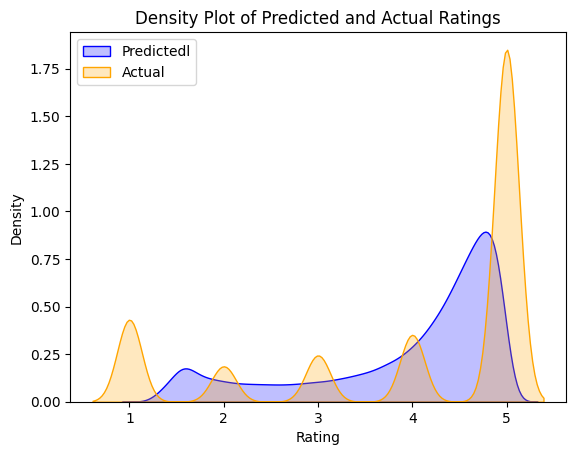

Best possible loss: 3.2505


In [470]:
test_user_node = torch.randint(0, len(user_mapping), (len(test_edge_index[0]), ))
test_product_node = torch.randint(len(user_mapping), len(user_mapping) + len(product_mapping), (len(test_edge_index[1]), ))
test_edge_index_random = torch.stack([test_user_node, test_product_node])
final_evaluation(base_gnn_model, test_edge_index_random, test_edge_weights, user_features, product_features, best_model, plot=True)

## Appendix 2: Visualize embeddings

Visualise review features and meta features of products, but did not find anything cool to report

In [ ]:
# Convert the tensor to a NumPy array
review_features_numpy = review_features.numpy()
meta_features_numpy = meta_features.numpy()

# Apply t-SNE
tsne = TSNE(n_components=2, random_state=42)
review_features_2d = tsne.fit_transform(review_features_numpy)
meta_features_2d = tsne.fit_transform(meta_features_numpy)

In [ ]:
# Sample the data for better visualization
sample_indices = np.random.choice(review_features_2d.shape[0], size=5000, replace=False)
review_features_2d_sampled = review_features_2d[sample_indices, :]
meta_features_2d_sampled = meta_features_2d[sample_indices, :]

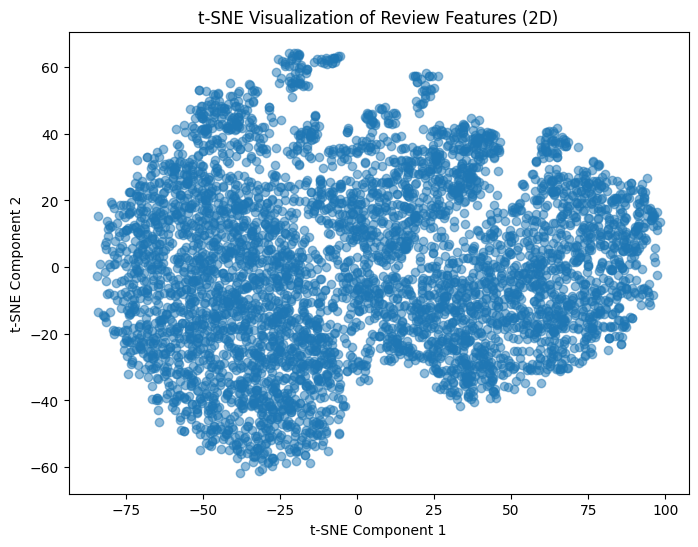

In [133]:
# Visualize the results
plot_embedding_features(review_features_2d_sampled)

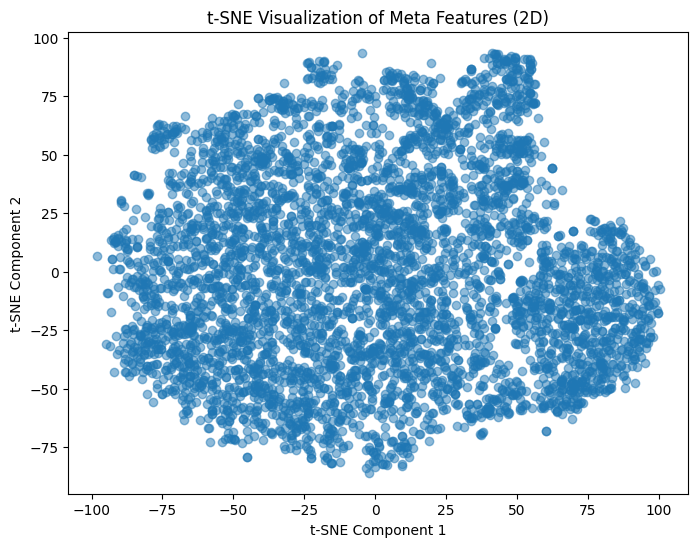

In [136]:
# Visualize the results
plot_embedding_features(meta_features_2d_sampled)